<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/deep_learning/105/minivggnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/minivggnet/minivggnet.zip
!unzip -qq minivggnet.zip
%cd minivggnet

--2023-02-23 10:59:57--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/minivggnet/minivggnet.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.249.81, 3.5.76.197, 52.218.170.34, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.249.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10844 (11K) [binary/octet-stream]
Saving to: ‘minivggnet.zip’

minivggnet.zip      100%[===================>]  10.59K  --.-KB/s    in 0s      

2023-02-23 10:59:58 (81.6 MB/s) - ‘minivggnet.zip’ saved [10844/10844]

/content/minivggnet


In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    Conv2D, 
    Dense, 
    Dropout,
    Flatten, 
    MaxPool2D
)
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

### Implementing MiniVGGNet

In [5]:
from sklearn.metrics.pairwise import kernel_metrics
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # init model
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1

        if K.image_data_format == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1

        # first set of CONV => RELU => CONV => RELU => POOL
        model.add(
            Conv2D(
                filters=32,
                kernel_size=(3, 3),
                padding="same",
                input_shape=input_shape
            )
        )
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(rate=0.25))

        # second set of CONV => RELU => CONV => RELU => POOL
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(rate=0.25))

        # first and only set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(rate=0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return constructed network architecture
        return model

### MiniVGGNet on CIFAR-10

In [6]:
# load data and rescale to [0, 1]
print("[INFO] loading CIFAR-10 data...")
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()
train_x = train_x.astype("float") / 255.0
test_x = test_x.astype("float") / 255.0

# convert labels from integer to vectors
le = LabelBinarizer()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

# init label names
label_names = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...
170498071/170498071 [==============================] - 2s 0us/step


In [7]:
# init optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

# train network
print("[INFO] training network...")
H = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    batch_size=64,
    epochs=40,
    verbose=1
)

[INFO] compiling model...
[INFO] training network...
Epoch 1/40
782/782 [==============================] - 359s 456ms/step - loss: 1.6735 - accuracy: 0.4446 - val_loss: 1.2607 - val_accuracy: 0.5629
Epoch 2/40
782/782 [==============================] - 355s 455ms/step - loss: 1.1822 - accuracy: 0.5927 - val_loss: 1.0970 - val_accuracy: 0.6148
Epoch 3/40
782/782 [==============================] - 352s 450ms/step - loss: 0.9862 - accuracy: 0.6610 - val_loss: 0.9154 - val_accuracy: 0.6744
Epoch 4/40
782/782 [==============================] - 351s 448ms/step - loss: 0.8834 - accuracy: 0.6959 - val_loss: 0.7999 - val_accuracy: 0.7226
Epoch 5/40
782/782 [==============================] - 352s 450ms/step - loss: 0.7991 - accuracy: 0.7219 - val_loss: 0.7553 - val_accuracy: 0.7331
Epoch 6/40
782/782 [==============================] - 350s 448ms/step - loss: 0.7336 - accuracy: 0.7447 - val_loss: 0.7659 - val_accuracy: 0.7352
Epoch 7/40
782/782 [==============================] - 344s 441ms/step -

In [8]:
# evaluate network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=64)
print(
    classification_report(
        test_y.argmax(axis=1),
        predictions.argmax(axis=1),
        target_names = label_names
    )
)

[INFO] evaluating network...
157/157 [==============================] - 27s 170ms/step
              precision    recall  f1-score   support

    airplane       0.88      0.84      0.86      1000
  automobile       0.89      0.94      0.91      1000
        bird       0.71      0.78      0.74      1000
         cat       0.72      0.62      0.67      1000
        deer       0.78      0.84      0.81      1000
         dog       0.79      0.72      0.76      1000
        frog       0.84      0.90      0.87      1000
       horse       0.88      0.87      0.87      1000
        ship       0.90      0.90      0.90      1000
       truck       0.90      0.88      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



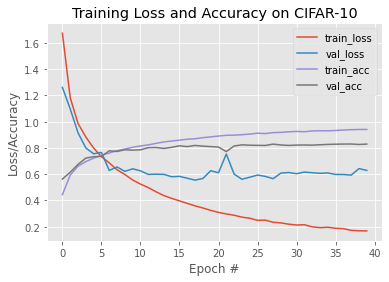

In [10]:
# plot training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()